In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import time
import json
import sys
sys.path.append("../../")

from src.context_aware.config import ModelConfig, DatasetConfig
from src.dataset_manager import DatasetConvertor 
from src.context_aware.preprocessing import PreparingDataset
from src.context_aware.models import createModel
from src.context_aware.training import createDataLoaders
from src.context_aware.evaluation import evaluateModel


In [2]:
rawDatasetFolder = "../../data/raw"
model_folder = "../../data/models/context_aware"
configPath = "../config/conbined_flows.json"

direction = "forward"
lenWindow = 20
verbose = True

In [3]:
config = json.load(open(configPath, "r"))
mapping = config.get("DIRECTION_MAPPING", {})
dpdr_params = config.get("dpdr_params", {})

datasetConverter = DatasetConvertor(rawDatasetFolder, config)
datasetConverter.processDataset(direction=direction, **dpdr_params[direction])
dataUnit = datasetConverter.getDataUnit(f"combined_{mapping[direction]}")

datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=False)
_, testData = PreparingDataset(dataUnit, datasetConfig, verbose=False)

modelConfig = ModelConfig.from_dataset(datasetConfig, testData)
model, device = createModel(modelConfig)
model.load_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")

========== Combined ============
Forward: Compression rate: 0.2328


(2080, 20, 12)
(2080, 20, 12)
(2080, 1)
(2080, 1, 12)
Avg. inference time:  0.003974547386169433


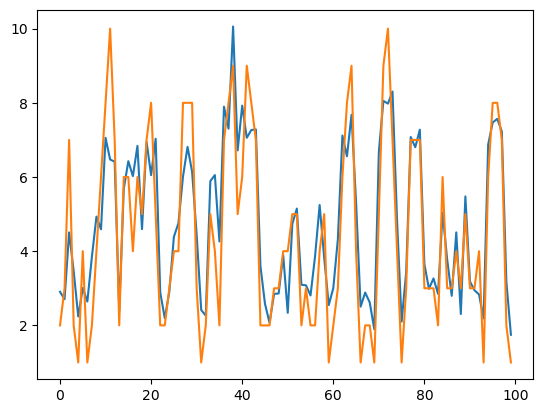

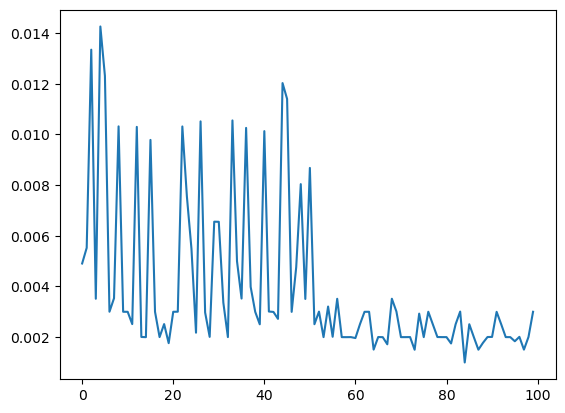

In [8]:
sources, _, last_trans_sources, _, traffic, _, _, sourcesNoSmooth = testData
print(sources.shape)
print(sourcesNoSmooth.shape)
print(traffic.shape)
print(last_trans_sources.shape)

output_list = []
inference_time_list = []

num_samples = sources.shape[0]
for i in range(100):
    start_time = time.time()
    output = model.inference(sources[i], last_trans_sources[i], sourcesNoSmooth[i])
    end_time = time.time()
    inference_time = end_time - start_time

    output_list.append(output)
    inference_time_list.append(inference_time)
print("Avg. inference time: ", np.mean(inference_time_list))
plt.plot(output_list)
plt.plot(traffic[0:len(output_list)])
plt.show()
plt.plot(inference_time_list)
plt.show()
